In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import numpy as np
import pandas as pd

In [3]:
%cd "/content/drive/MyDrive/CV8160 S24/HW2"

/content/drive/MyDrive/CV8160 S24/HW2


In [4]:
!ls

'Data Introduction & Process.ipynb'   HW2.ipynb   __pycache__	  Test	       utils.py
 data.py			      model.py	  rnn_model.pth   tps_df.pkl


In [5]:
from data import TrafficDataset
from utils import training_model, evaluataion, TestSetup
from model import MyGRU, MyLSTM, MyRNN

In [7]:
window=10
horizon=12
train_dataset = TrafficDataset("tps_df.pkl", window=10, horizon=12)
validation_dataset = TrafficDataset("tps_df.pkl", window=10, horizon=12, task='validation')

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=1024, num_workers=10, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1024, num_workers=10, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## RNN

In [10]:
#rnn training
n_epochs = 15
model_path = 'rnn_model.pth'
rnn_model = MyRNN(input_size=3, hidden_size=15, num_layers=2, device=device, output_size=horizon)
rnn_model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.0001)
mean_train_loss, mean_val_loss, train_losses, val_losses, model = training_model(rnn_model, criterion, optimizer, train_dataloader, validation_dataloader
                                                                                 ,n_epochs, device)
torch.save(model.state_dict(), model_path)

  0%|          | 0/988 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 988/988 [00:46<00:00, 21.44it/s]


Epoch 1/15, Training Loss: 0.4046, Validation Loss: 0.0709


100%|██████████| 988/988 [00:36<00:00, 27.06it/s]


Epoch 2/15, Training Loss: 0.2157, Validation Loss: 0.0417


100%|██████████| 988/988 [00:39<00:00, 25.10it/s]


Epoch 3/15, Training Loss: 0.1478, Validation Loss: 0.0317


100%|██████████| 988/988 [00:37<00:00, 26.06it/s]


Epoch 4/15, Training Loss: 0.1138, Validation Loss: 0.0267


100%|██████████| 988/988 [00:41<00:00, 24.02it/s]


Epoch 5/15, Training Loss: 0.0933, Validation Loss: 0.0236


100%|██████████| 988/988 [00:32<00:00, 30.64it/s]


Epoch 6/15, Training Loss: 0.0797, Validation Loss: 0.0216


100%|██████████| 988/988 [00:46<00:00, 21.24it/s]


Epoch 7/15, Training Loss: 0.0700, Validation Loss: 0.0201


100%|██████████| 988/988 [00:33<00:00, 29.17it/s]


Epoch 8/15, Training Loss: 0.0625, Validation Loss: 0.0186


100%|██████████| 988/988 [00:40<00:00, 24.43it/s]


Epoch 9/15, Training Loss: 0.0564, Validation Loss: 0.0173


100%|██████████| 988/988 [00:39<00:00, 25.33it/s]


Epoch 10/15, Training Loss: 0.0515, Validation Loss: 0.0163


100%|██████████| 988/988 [00:42<00:00, 23.51it/s]


Epoch 11/15, Training Loss: 0.0474, Validation Loss: 0.0154


100%|██████████| 988/988 [00:34<00:00, 28.55it/s]


Epoch 12/15, Training Loss: 0.0440, Validation Loss: 0.0147


100%|██████████| 988/988 [00:42<00:00, 23.49it/s]


Epoch 13/15, Training Loss: 0.0412, Validation Loss: 0.0141


100%|██████████| 988/988 [00:39<00:00, 25.12it/s]


Epoch 14/15, Training Loss: 0.0387, Validation Loss: 0.0135


100%|██████████| 988/988 [00:43<00:00, 22.87it/s]


Epoch 15/15, Training Loss: 0.0366, Validation Loss: 0.0130


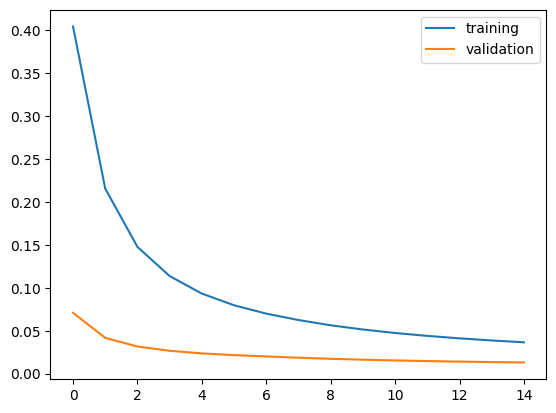

In [11]:
plt.plot(mean_train_loss, label='training')
plt.plot(mean_val_loss, label='validation')
plt.legend()

In [12]:
eval = evaluataion(rnn_model, "rnn_model.pth", validation_dataloader, device)
print(f"Traffic Index DOW/Hour. RMSE: {eval['rmse']}, MAE: {eval['mae']}")

Traffic Index DOW/Hour. RMSE: 0.276385180921564, MAE: 0.3763567805290222


In [13]:
test_dir = Path('Test')
test_files = list(test_dir.glob('*.pkl'))
for i, file in enumerate(test_files):
    test_obj = TestSetup(rnn_model, model_path, file, device, window, horizon)
    test_obj.prediction()
    if i == 0:
        final_output = test_obj.pred
    else:
        final_output = pd.concat([final_output, test_obj.pred])

print(final_output.shape)
final_output.index = final_output.index.astype(int) / 10**9
final_output.to_json('RNN_Prediction.json')


(180, 87)


## GRU

In [16]:
#rnn training
n_epochs = 15
model_path = 'gru_model.pth'
gru_model = MyGRU(input_size=3, hidden_size=15, num_layers=2, device=device, output_size=horizon)
gru_model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.0001)
mean_train_loss, mean_val_loss, train_losses, val_losses, model = training_model(gru_model, criterion, optimizer, train_dataloader, validation_dataloader
                                                                                 ,n_epochs, device)
torch.save(model.state_dict(), model_path)

 53%|█████▎    | 521/988 [00:24<01:08,  6.77it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Traceback (most recent call last):

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
if w.is_alive():Traceback (most recent call last):
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_ali

Epoch 1/15, Training Loss: 0.4984, Validation Loss: 0.1465


 40%|████      | 399/988 [00:15<00:31, 18.70it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>    Traceback (most recent call last):

assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in: 
Traceback (most recent call last):
 41%|████      | 401/988 [00:2

Epoch 2/15, Training Loss: 0.2804, Validation Loss: 0.0832


 74%|███████▎  | 728/988 [00:29<00:24, 10.51it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdo

Epoch 3/15, Training Loss: 0.1915, Validation Loss: 0.0593


 36%|███▌      | 355/988 [00:16<00:16, 38.93it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
Exception ignored in: Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60><function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
Excep

Epoch 4/15, Training Loss: 0.1465, Validation Loss: 0.0474


 72%|███████▏  | 712/988 [00:34<02:53,  1.59it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dat

Epoch 5/15, Training Loss: 0.1195, Validation Loss: 0.0402


 39%|███▊      | 381/988 [00:21<07:27,  1.36it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in: 
Exception ignored in: 
    Traceback (most recent call last):
 39%|███▉      | 384/988 [00:21<05:19,  1.89it/s]  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py

Epoch 6/15, Training Loss: 0.1015, Validation Loss: 0.0353


 70%|███████   | 694/988 [00:26<00:07, 39.02it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60><function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

 71%|███████   | 698/988 [00:28<00:50,  5.69it/s]      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():    
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>Exception ignored in: Exception ignored in: if w

Epoch 7/15, Training Loss: 0.0884, Validation Loss: 0.0314


 35%|███▌      | 346/988 [00:17<00:44, 14.38it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", l

Epoch 8/15, Training Loss: 0.0784, Validation Loss: 0.0285


 66%|██████▌   | 653/988 [00:25<00:09, 35.36it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 67%|██████▋   | 660/988 [00:28<00:55,  5.93it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60><function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60><function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>


Traceback (most recent call last):
Trace

Epoch 9/15, Training Loss: 0.0705, Validation Loss: 0.0261


 33%|███▎      | 323/988 [00:12<01:09,  9.60it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
 33%|███▎      | 327/988 [00:12<00:54, 12.03it/s]self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
 33%|███▎      | 330/988 [00:12<00:49, 13.36it/s]    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
 34%|███▎      | 333/988 [00:19<06:57,  1.57it/s]  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479,

Epoch 10/15, Training Loss: 0.0642, Validation Loss: 0.0242


 66%|██████▌   | 651/988 [00:32<03:36,  1.55it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Exception ignored in: 
Traceback (most recent call last):
 66%|██████▋   | 655/988 [00:32<02:25,  2.28it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in: 
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60><function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60><function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>Traceback (most recent call last):
Ex

Epoch 11/15, Training Loss: 0.0590, Validation Loss: 0.0226


 33%|███▎      | 327/988 [00:16<00:27, 24.11it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
 33%|███▎      | 330/988 [00:17<01:34,  6.99it/s]
AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line

Epoch 12/15, Training Loss: 0.0546, Validation Loss: 0.0212


 62%|██████▏   | 615/988 [00:26<01:14,  5.02it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Exception ignored in: 
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Traceback (most recent call last):
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
if w.is_alive():

    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is

Epoch 13/15, Training Loss: 0.0509, Validation Loss: 0.0201


 32%|███▏      | 318/988 [00:15<00:18, 35.81it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>    self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>

self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers


Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1

Epoch 14/15, Training Loss: 0.0477, Validation Loss: 0.0191


 60%|██████    | 596/988 [00:23<00:09, 40.28it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60><function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    Traceback (most recent call last):

 61%|██████    | 601/988 [00:26<01:10,  5.45it/s]  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in:         <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60

Epoch 15/15, Training Loss: 0.0450, Validation Loss: 0.0182


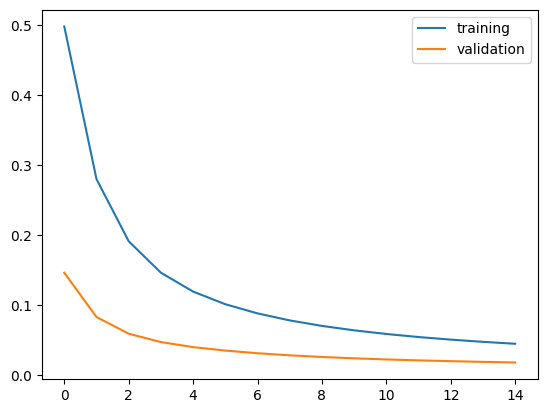

In [17]:
plt.plot(mean_train_loss, label='training')
plt.plot(mean_val_loss, label='validation')
plt.legend()

In [18]:
eval = evaluataion(gru_model, model_path, validation_dataloader, device)
print(f"Traffic Index DOW/Hour. RMSE: {eval['rmse']}, MAE: {eval['mae']}")

Traffic Index DOW/Hour. RMSE: 0.26998982959183404, MAE: 0.3635849356651306


In [19]:
test_dir = Path('Test')
test_files = list(test_dir.glob('*.pkl'))
for i, file in enumerate(test_files):
    test_obj = TestSetup(gru_model, model_path, file, device, window, horizon)
    test_obj.prediction()
    if i == 0:
        final_output = test_obj.pred
    else:
        final_output = pd.concat([final_output, test_obj.pred])

print(final_output.shape)
final_output.index = final_output.index.astype(int) / 10**9
final_output.to_json('GRU_Prediction.json')

(180, 87)


##LSTM

In [20]:
n_epochs = 15
model_path = 'lstm_model.pth'
lstm_model = MyLSTM(input_size=3, hidden_size=15, num_layers=2, device=device, output_size=horizon)
lstm_model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0001)
mean_train_loss, mean_val_loss, train_losses, val_losses, model = training_model(lstm_model, criterion, optimizer, train_dataloader, validation_dataloader
                                                                                 ,n_epochs, device)
torch.save(model.state_dict(), model_path)

  0%|          | 0/988 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 29%|██▉       | 291/988 [00:17<05:27,  2.13it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Exception ignored in: Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIte

Epoch 1/15, Training Loss: 0.4541, Validation Loss: 0.0447


 19%|█▉        | 189/988 [00:15<04:11,  3.18it/s]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in: Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>if w.is_alive():Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
    
    self._shutdown_workers()self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.10/dist-packages/torch/uti

Epoch 2/15, Training Loss: 0.2365, Validation Loss: 0.0282


 47%|████▋     | 464/988 [00:21<00:55,  9.50it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        ass

Epoch 3/15, Training Loss: 0.1614, Validation Loss: 0.0224


 16%|█▌        | 155/988 [00:06<00:22, 36.31it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Traceback (most recent call last):
    
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/datal

Epoch 4/15, Training Loss: 0.1237, Validation Loss: 0.0192


 43%|████▎     | 427/988 [00:18<00:14, 38.73it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
 44%|████▎     | 431/988 [00:19<00:37, 14.89it/s]    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 46%|████▋     | 457/988 [00:20<00:26, 20.39it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/to

Epoch 5/15, Training Loss: 0.1008, Validation Loss: 0.0171


 15%|█▍        | 148/988 [00:05<00:24, 34.07it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        ass

Epoch 6/15, Training Loss: 0.0854, Validation Loss: 0.0156


 41%|████▏     | 408/988 [00:16<00:26, 21.64it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Exception ignored in:       File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/us

Epoch 7/15, Training Loss: 0.0743, Validation Loss: 0.0145


 14%|█▍        | 139/988 [00:05<00:26, 32.59it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>if w.is_alive():self._shutdown_workers()


  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in 

Epoch 8/15, Training Loss: 0.0660, Validation Loss: 0.0136


 35%|███▍      | 344/988 [00:15<00:31, 20.39it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Exception ignored in: Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60><function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in: 
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3

Epoch 9/15, Training Loss: 0.0595, Validation Loss: 0.0129


 13%|█▎        | 130/988 [00:05<00:39, 21.81it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:         <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
self._shutdown_workers()Exception ignored in: 

Traceback (most recent call last):

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _sh

Epoch 10/15, Training Loss: 0.0543, Validation Loss: 0.0124


 31%|███       | 302/988 [00:15<00:19, 35.30it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
if w.is_alive():
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdo

Epoch 11/15, Training Loss: 0.0501, Validation Loss: 0.0119


  9%|▉         | 92/988 [00:05<00:33, 26.58it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>AssertionError: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()

  File "/usr/l

Epoch 12/15, Training Loss: 0.0465, Validation Loss: 0.0115


 27%|██▋       | 264/988 [00:10<00:31, 22.93it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
 27%|██▋       | 267/988 [00:13<03:45,  3.20it/s]    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>AssertionError
: Traceback (most recent call last):
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
 27%|██▋       | 270/988 [00:13<02:47,  4.27it/s]
    Exception ignored in: Excepti

Epoch 13/15, Training Loss: 0.0434, Validation Loss: 0.0111


  8%|▊         | 83/988 [00:03<00:26, 34.40it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/li

Epoch 14/15, Training Loss: 0.0408, Validation Loss: 0.0108


 23%|██▎       | 223/988 [00:16<07:58,  1.60it/s]<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
self._shutdown_workers()Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in: 
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
 23%|██▎       | 225/988 [00:16<06:09,  2.07it/s]  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()    Exception ignored in: 
<function _MultiProce

Epoch 15/15, Training Loss: 0.0385, Validation Loss: 0.0105


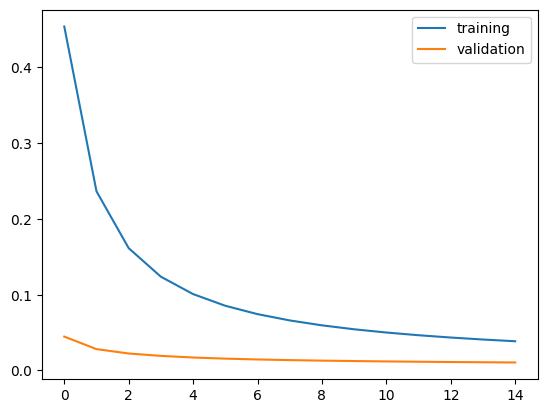

In [21]:
plt.plot(mean_train_loss, label='training')
plt.plot(mean_val_loss, label='validation')
plt.legend()

In [22]:
eval = evaluataion(lstm_model, model_path, validation_dataloader, device)
print(f"Traffic Index DOW/Hour. RMSE: {eval['rmse']}, MAE: {eval['mae']}")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e2fbc2ddc60>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
self._shutdown_workers()    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

  File "/us

Traffic Index DOW/Hour. RMSE: 0.2781630518536806, MAE: 0.36005380749702454


In [23]:
test_dir = Path('test_data')
test_files = list(test_dir.glob('*.pkl'))
for i, file in enumerate(test_files):
    test_obj = TestSetup(lstm_model, model_path, file, device, window, horizon)
    test_obj.prediction()
    if i == 0:
        final_output = test_obj.pred
    else:
        final_output = pd.concat([final_output, test_obj.pred])

print(final_output.shape)
final_output.index = final_output.index.astype(int) / 10**9
final_output.to_json('LSTM_Prediction.json')

(180, 87)
